In [37]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import plotnine as pn


## 1. The data and problem

For this lesson, we'll work with a new dataset of unknown origin (for the moment). 

In a not too unbelievable scenario, imagine that your boss has given you these data and said, "I don't really know what all of this stuff means, but I need you to model this and get me a model to predict $y$ using these data!", and of course they add, "I need this by the end of the day!"
![Drawing of a boss and person at computer](images/the_boss_small.jpg)


Let's load the data and start looking at it...

In [38]:
df = pd.read_csv('data/regularization.csv')

In [39]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,0.126504,0.477706,0.313475,0.514386,0.743750,0.234681,0.671997,0.270976,0.519267,0.361153,...,0.571807,0.281180,0.814374,0.527172,0.550691,0.021509,0.028173,0.837283,0.261703,4.077128
1,0.121590,0.483381,0.724387,0.818556,0.872479,0.441711,0.795640,0.474486,0.157817,0.251904,...,0.403155,0.372762,0.226465,0.002351,0.089564,0.913374,0.911584,0.784988,0.035362,4.981252
2,0.698551,0.036947,0.723721,0.459921,0.602351,0.560279,0.028867,0.414398,0.104540,0.906528,...,0.960674,0.529909,0.911473,0.828246,0.468373,0.582552,0.527382,0.470915,0.756324,6.649698
3,0.198011,0.724938,0.713586,0.493570,0.812774,0.665962,0.496994,0.145470,0.929903,0.299357,...,0.370109,0.862206,0.275417,0.717374,0.265629,0.952450,0.387913,0.477727,0.566269,6.034292
4,0.160674,0.462549,0.399120,0.062895,0.933785,0.942120,0.269115,0.780801,0.452808,0.047896,...,0.766598,0.838162,0.351654,0.207323,0.760390,0.860970,0.993952,0.417981,0.991003,7.588461


What should we do with this? We have 20 $x$ variables and 50 observations of those variables. How can we build a good predictive model for these data?

Where do we start?

Once we're ready to start looking at models, how do we select variables?

### Number of possible models

As a bit of an aside, model selection quickly blows up if we want to try all possible combinations. The table below shows the number of models that would need to be evaluated for $p$ features or predictors.

$p$ (number of predictors): | 1      | 2     | 10    | 20    | 40    | 100 
--------------------------|--------|---------|-------|-------|-------|-----
No of models for $p$ predictors| 2   |  4    | 1,024 | 1,0448,576| 1.1 X 10<sup>12</sup> | 1.3 X 10<sup>30</sup>
Add square of each predictor | 4 | 16 | 1,048,576 | 1.1 X 10<sup>12</sup> | 1.2 X 10<sup>24</sup> | 1.6 X 10<sup>60</sup>
Add pairwise interactions | 2 | 5 | 3.6 X 10<sup>13</sup> | 1.6 X 10<sup>57</sup> | 6.4 X 10<sup>234</sup> | ? 🤯 

**Fun fact:** Estimated number of atoms in the observable universe: ~10<sup>80</sup>

So...with 20 features, we are approaching the number of atoms in the uniSverse...

Somehow need to control for the number of parameters in our model!


## 2. Multiple linear regression

Let's explore multiple linear regression first to see what happens. _Note that, in the interest of time, I am leaving out exploratory data analyses and visualizations, which is where you should start!_

In [40]:
# Get the dataset ready
 
 
# Create and fit a simple LinearRegression model


def mse(model, X, y):
    y_hat = model.predict(X)
    err = np.mean((y - y_hat)**2)
    return err

print('R^2:', model.score(X, y), 'MSE:', mse(model, X, y))

R^2: 0.9679699534659556 MSE: 0.07828974536159014


Now that we've got a model, let's use 5-fold cross-validation to estimate how well it will work for new (i.e., non-training) data.

In [41]:


print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

c-v R^2: 0.7734350974615244 c-v MSE: 0.38341921219406305


## 3. Lasso regularization

Remember that a model that is too complex, we tend to overfit the training data and get high variance, and if it's not complex enough, we underfit the training data and get high bias. Our goal is to find the model with just enough complexity. We can try to do this as part of the model optimization procedure.

So far, we've user the $MSE$ as our loss function. And our models look something like this:

$$ \hat{y} = b_0 + b_{1}x_{1} + b_{2}x_{2} + \ldots + b_{p}x_{p} $$

Let's define:  $\ell_1 penalty = \lambda \sum_{i=1}^{p} |b_{p}|$

And then we can make a new loss function that is: 

   $$  loss = MSE +  \lambda \sum_{i=1}^{p} |b_{p}|$$

As the coefficient for a feature increases, the $\ell_1 penalty$ also increases. If the model can push the $b$ for a feature to 0, that feature drops out of the model. By adjusting $\lambda$, we can adjust the effect of the $\ell_1 penalty$.

This is known as the Lasso, short for **l**east **a**bsolute **s**hrinkage and **s**election **o**perator.

Okay, so let's see what the lasso ($\ell_1$-regularized regression) does with these data.  We can use scikit-learn's `Lasso` estimator for this.  Note that scikit-learn uses `alpha` for the name of the parameter referred to as $\lambda$ virtually everywhere else (perhaps because `lambda` is a reserved word in Python).

As a general practice, you should always **make sure that your predictor variables are on the same scale when fitting a regularized regression model**.  We can have `Lasso` do this for us automatically by passing `normalize=True` when we create the `Lasso` object.

In [42]:



res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

[-0.          1.74023441  0.          2.55563706 -0.          0.04030546
  0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.38676971 -0.          0.69308938
  0.          3.96090209]
c-v R^2: 0.9085724964244137 c-v MSE: 0.1856678640282654


## 4. Ridge regression

Another method with similar goals, but different results is known as ridge regression. This uses what is referred to as the $\ell_1 penalty$

Let's define:  $\ell_2 penalty = \lambda \sum_{i=1}^{p} b_{p}^{2}$

Again, we can add the $\ell_1 penalty$ to the $MSE$.

Let's see what happens if we use ridge regression ($\ell_2$-regularized regression) with these data.  We can use scikit-learn's `Ridge` estimator to do this, and again, don't forget to make sure that your predictor variables are on the same scale.

All we need to do is copy the code from above and change `Lasso` to `Ridge` in the `model` line. The $\lambda$/`alpha` values have different effects.

[ 7.63682077e-05  1.00154748e-03  8.44346232e-04  2.57988981e-03
 -8.40003829e-04  1.31574521e-03  7.60368873e-05  1.67512363e-04
  2.40974311e-04  1.33912243e-05 -5.31923545e-04 -9.82878522e-04
  4.16529484e-04 -1.05307802e-03  1.42622322e-03  1.73305030e-03
  2.64957843e-04  5.07204122e-04 -9.63096337e-04  3.89300983e-03]
c-v R^2: -0.19417050653980628 c-v MSE: 2.5398869633291987


## 5. How does $\lambda$ influence the parameter estimates?

Before we move on, let's take a closer look at how changing lambda influences the parameter estimates for both the lasso and ridge regression.

**Affect of $\lambda$ in Lasso Regression**

![Graph showing how the features drop out as lambda is increased with Lasso. 4 key features are highlighted](images/Lasso_feature_dropout.png)

**Affect of $\lambda$ in Ridge Regression**

![Graph showing how the features drop out as lambda is increased with Ridge. 4 key features are highlighted](images/Ridge_feature_dropout.png)


Lasso and ridge regression are examples of *regularization* or *shrinkage* methods, because they regularize/constrain the parameter estimates by shrinking them towards 0.

## 6. Choosing $\lambda$ and a modeling procedure

How should we choose the "best" value of $\lambda$ for the lasso or ridge regression?  How should we decide whether to use the lasso or ridge regression?  What ideas do you have?

[-0.          1.72975135  0.          2.54682211 -0.          0.03635612
  0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.38346476 -0.          0.68477174
  0.          3.95204938]
Lambda: 0.010312186772825561
c-v R^2: 0.8924462779664101 c-v MSE: 0.22780219539690322


In [52]:
lambdas = np.geomspace(0.1, 10, 100) # Unlike LassoCV, we need to provide the lambds, here we use a logarithmic scale.
                                    # Note that we need to update the search range--0.001 should be good in the end.


[ 4.01741600e-02  1.70867833e+00 -8.13488095e-03  2.55428480e+00
 -6.58900869e-02  3.58797050e-01  7.29375999e-02  1.60369640e-02
  1.96833899e-01  6.20966733e-02 -1.87935489e-01 -1.74614783e-02
  1.10110313e-02  2.39105430e-01  5.19876052e-04  6.76011098e-01
 -1.11593813e-01  8.22592569e-01 -1.81990939e-01  3.72627101e+00]
Lambda: 0.1
c-v R^2: 0.7457186398711244 c-v MSE: 0.4965315463091534


## 7. Why/how do these methods work? Is one better than the other?

We'll start by revealing where the data we've been modeling actually came from, which will give us some insight into how these methods work.  Then we'll dig a little deeper into how these methods are able to decrease the expected test error.

These data were generated using: $y=1+ 2x_2 + 3x_4 + x_{18} + 4x_{20} + \epsilon ;    Var[\epsilon = 0.4] $

Look back the coefficients Lasso selected. Quite amazing!

### Returning to the bias-variance trade-off

The graph below shows the estimated test $MSE$ for models fit to data generated with the process used to generate the data we used in red. In blue is the Bias estimate and in green the variance. The vertical dashed line is the selected $\lambda$

![Graph of the estimated test MSE for models fit to data generated with the process used to generate the data we used in red. In blue is the Bias estimate and in green the variance.](images/Lasso_Bias-Variance_trade-off.png)
 
Notice that the model selected by Lasso does have bias! But we are trading a big reduction in variance for a small increase in bias.


### Key points to remember:

* The Lasso can drive coefficients to 0; thus, it can perform _feature selection_.
* Ridge regression constrains coefficient values (_shrinks_ them), but does not remove them from the model.

Which is best depends on your data and the goals of the analysis. In our case, most of the parameters were just noise, so Lasso performed better. If all of the parameters really played into generating the data, Ridge regression likely would have done better. **It depends on the data!**

## 8. Other methods

There are many other methods available for model/feature selection.  If you've had a statistics course, you've no doubt learned some of them.

Unfortunately, we don't have time to cover any of these alternative methods in detail in this course.  I will mention, though, that _dimensionality reduction_ is another widely used, general approach to dealing with model complexity and certainly worth learning about.  _Principle components regression_ is one example of this approach. One downside is that the models are less interpretable.

Another method I should mention is the _elastic net_, which combines $\ell_1$ and $\ell_2$ penalties into a single fitting procedure and can benefit from the desirable properties of both the lasso and ridge regression.

## 9. Data analysis lab, 0214 In-class notebook

Now, put together everything that you've learned over the last few units (prediction error, bias and variance; methods for estimating test/prediction error; regularization techniques) and apply it to a data analysis problem.  Returning to the diabetes dataset, your goal is to create a machine learning model that can accurately predict the diabetes risk.

### data loading

In [ ]:
!pip install plotnine

In [24]:
from sklearn.datasets import load_diabetes
import plotnine as pn
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### data summary and EDA

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [34]:
# check the skewness of the Outcome variable
from scipy.stats import skew
skew(df)

array([ 0.89991194,  0.17341396, -1.84000523,  0.10915876,  2.26781046,
       -0.42814328,  1.9161592 ,  1.12738926,  0.6337757 ])

In [6]:
# duplicated rows
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 0


In [8]:
# missing values
print("Number of missing values:", df.isnull().sum())

Number of missing values: Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


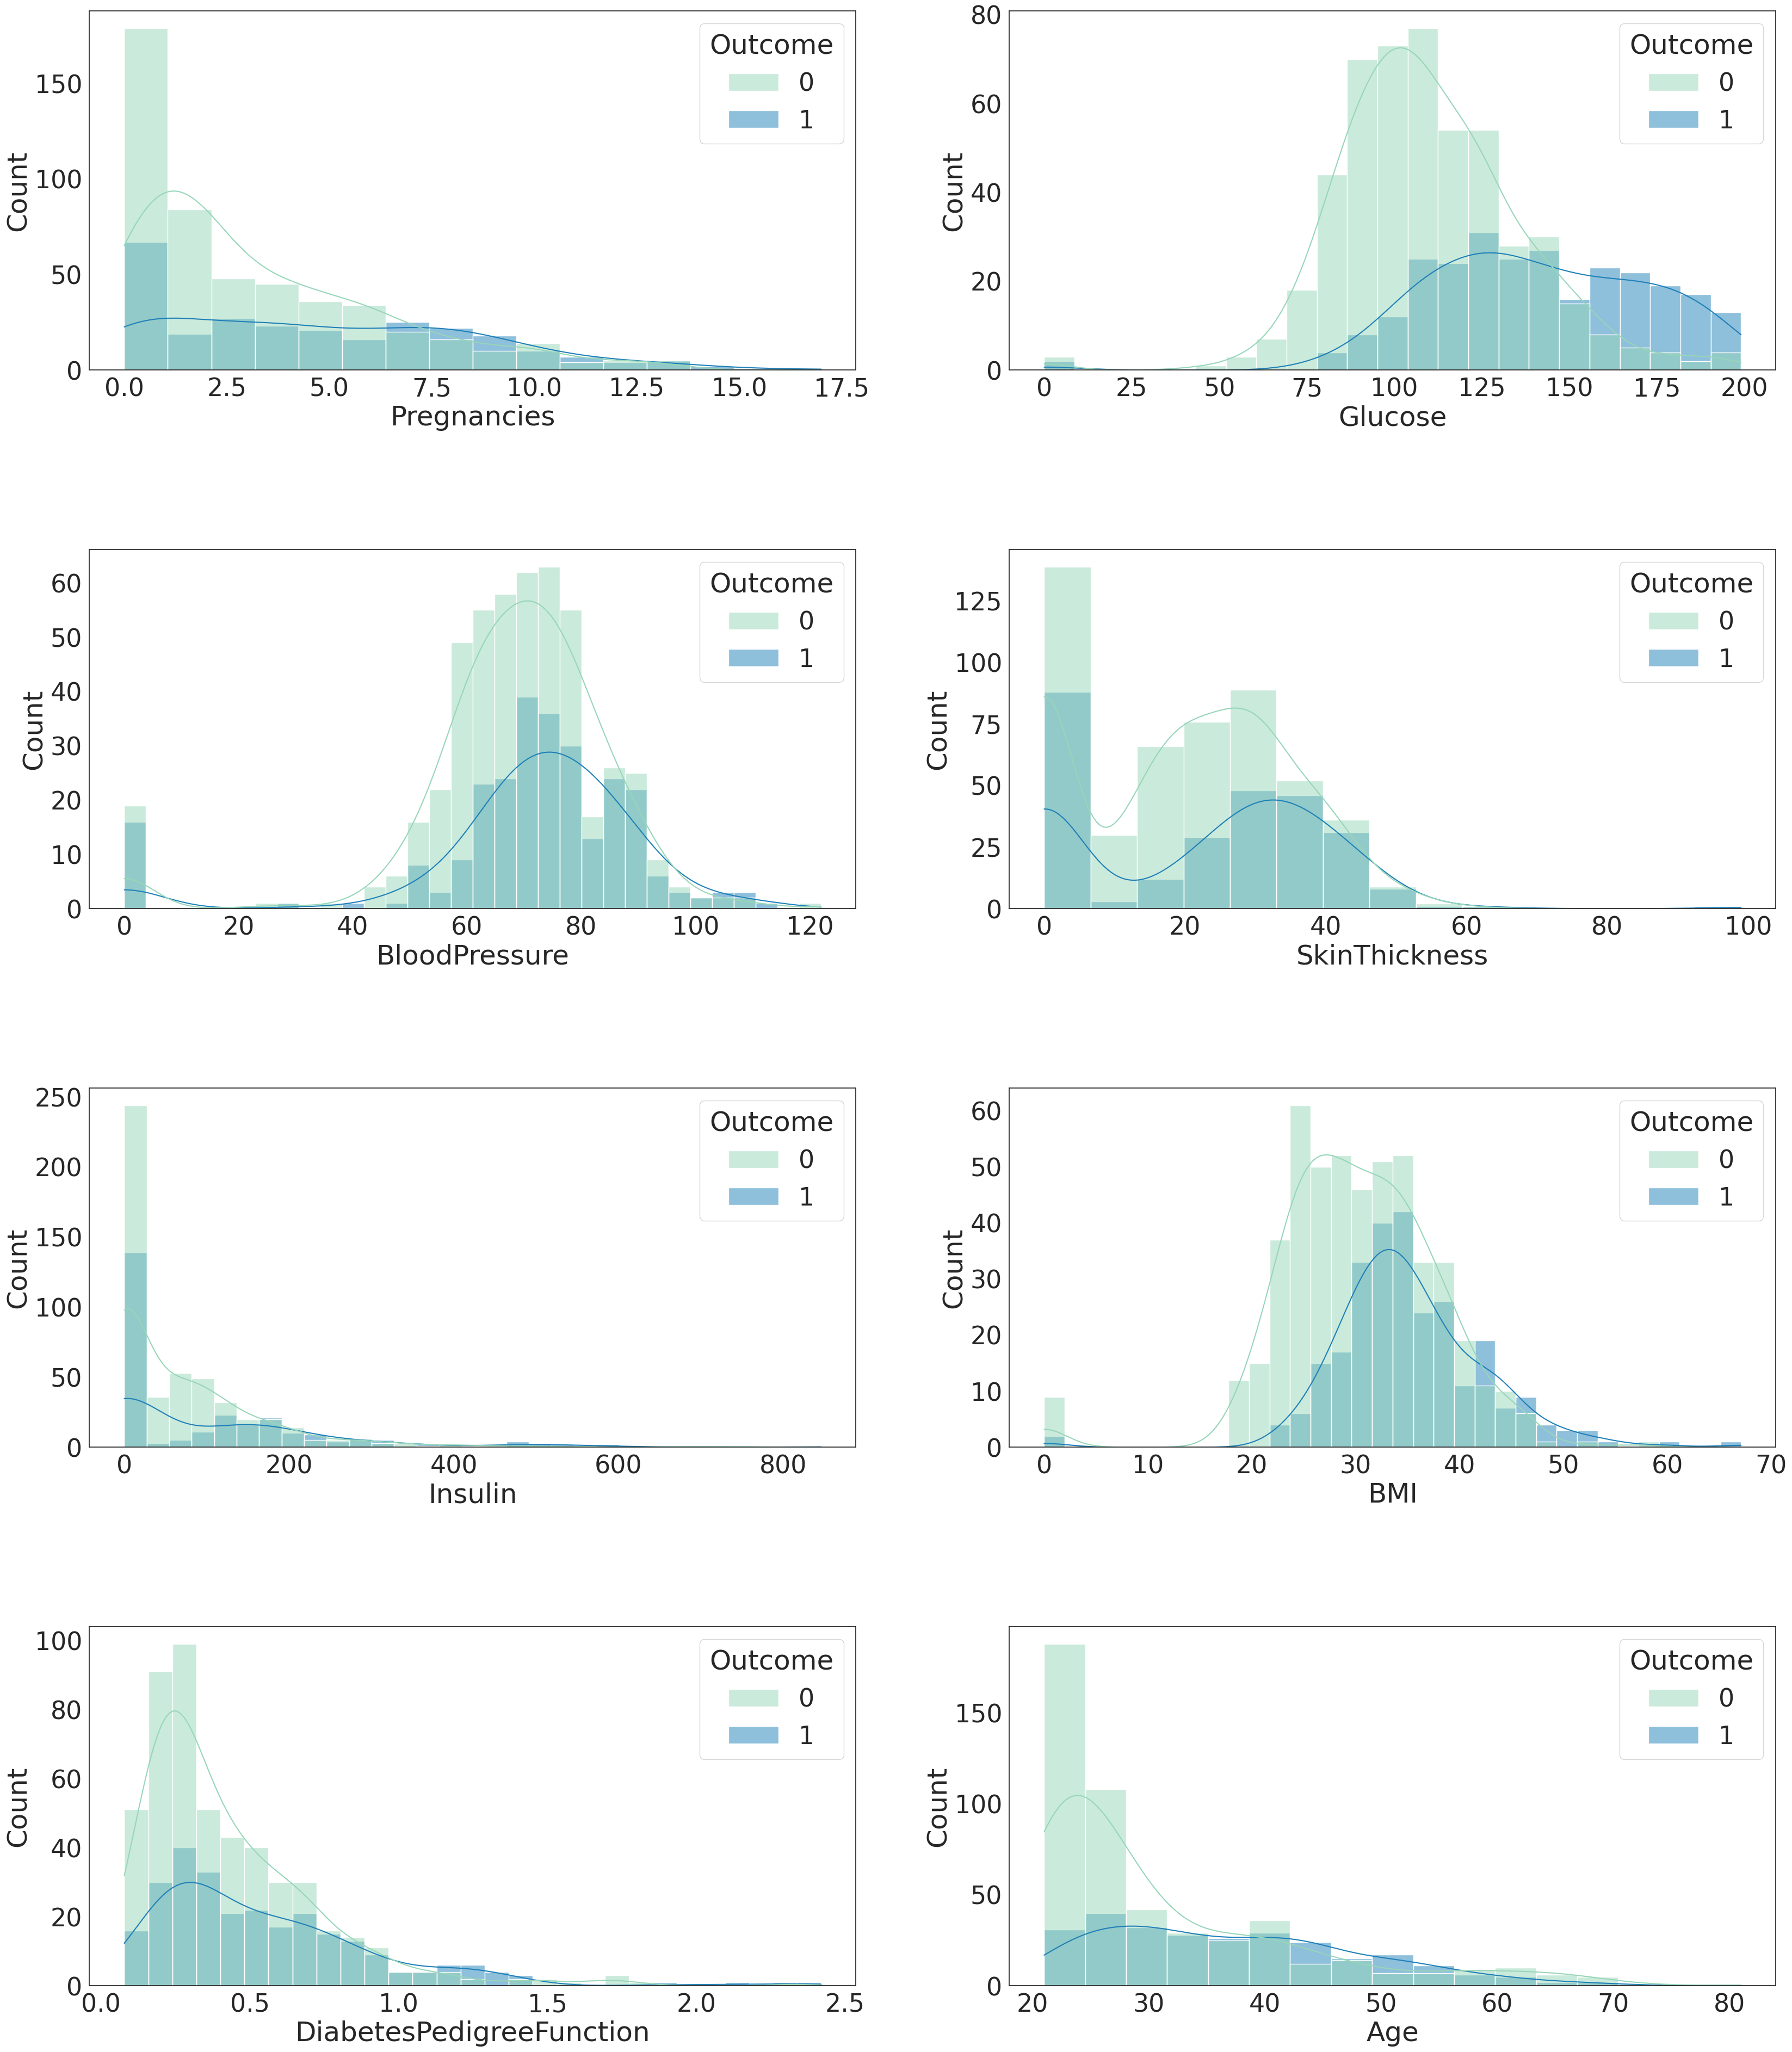

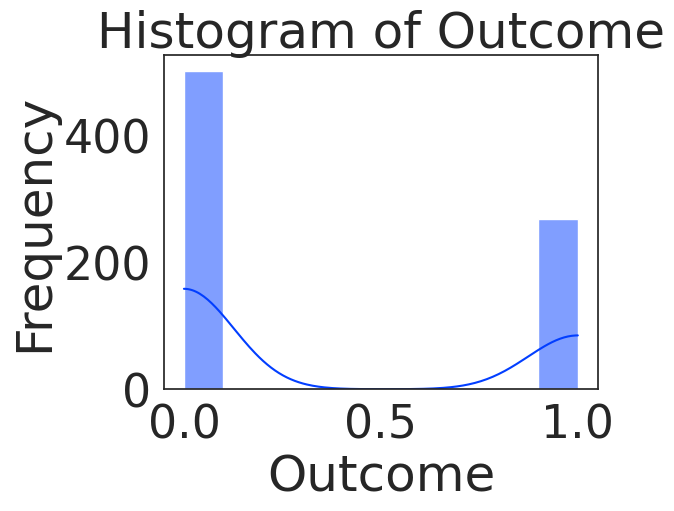

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
# draw the distribution of features and target variable
features = df.drop(columns=['Outcome'], axis = 1, inplace = False)
target = 'Outcome'

# set the style of the plot
sns.set_style("whitegrid")

# draw the distribution of each features
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in features:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

# draw the distribution of target variable
# Create subplots for histogram and box plot
plt.figure(figsize=(12, 6))

# Histogram for 'Rings'
plt.subplot(1, 2, 1)  
sns.histplot(df['Outcome'], bins=10, kde=True)  
plt.title('Histogram of Outcome')
plt.xlabel('Outcome')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

There are some outliers (Glucose = 0, BloodPressure = 0, SkinThickness = 0， Insulin = 0， BMI = 0)

In [3]:
zero_features = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = df['Glucose'].count()

for feature in zero_features:
    zero_count = df[df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


**change the outliers to mean values**

In [4]:
diabetes_mean = df[zero_features].mean()
df[zero_features]=df[zero_features].replace(0, diabetes_mean)

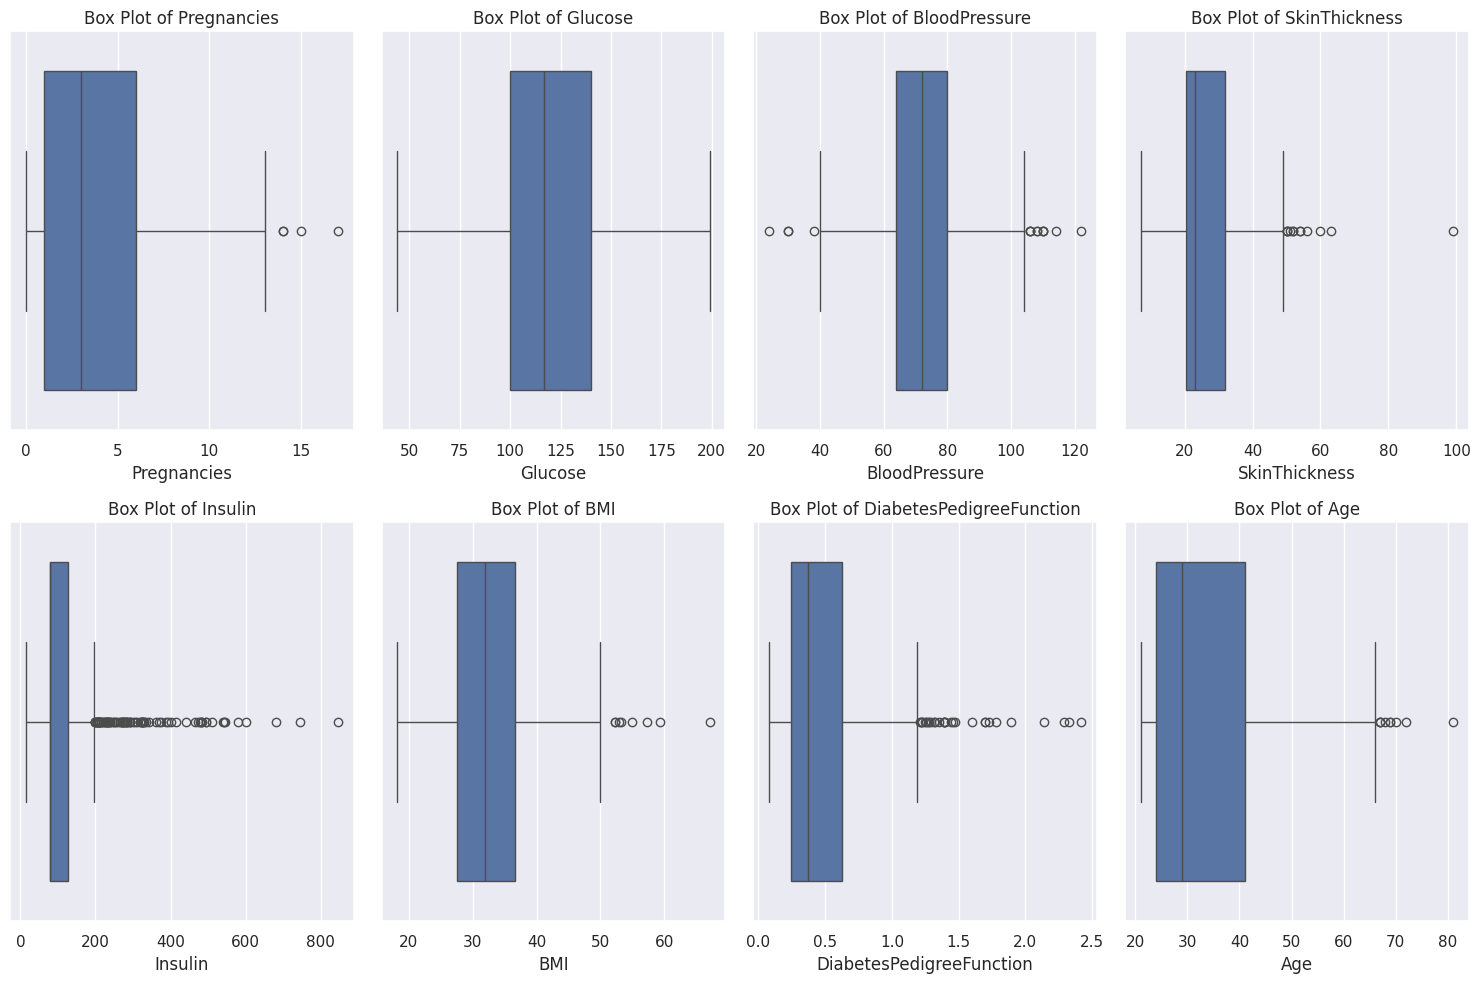

In [15]:
# box plot for each features
sns.set(font_scale = 1)
plt.figure(figsize=(15, 10))
for i, column in enumerate(features):
    plt.subplot(2, 4, i + 1)  
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

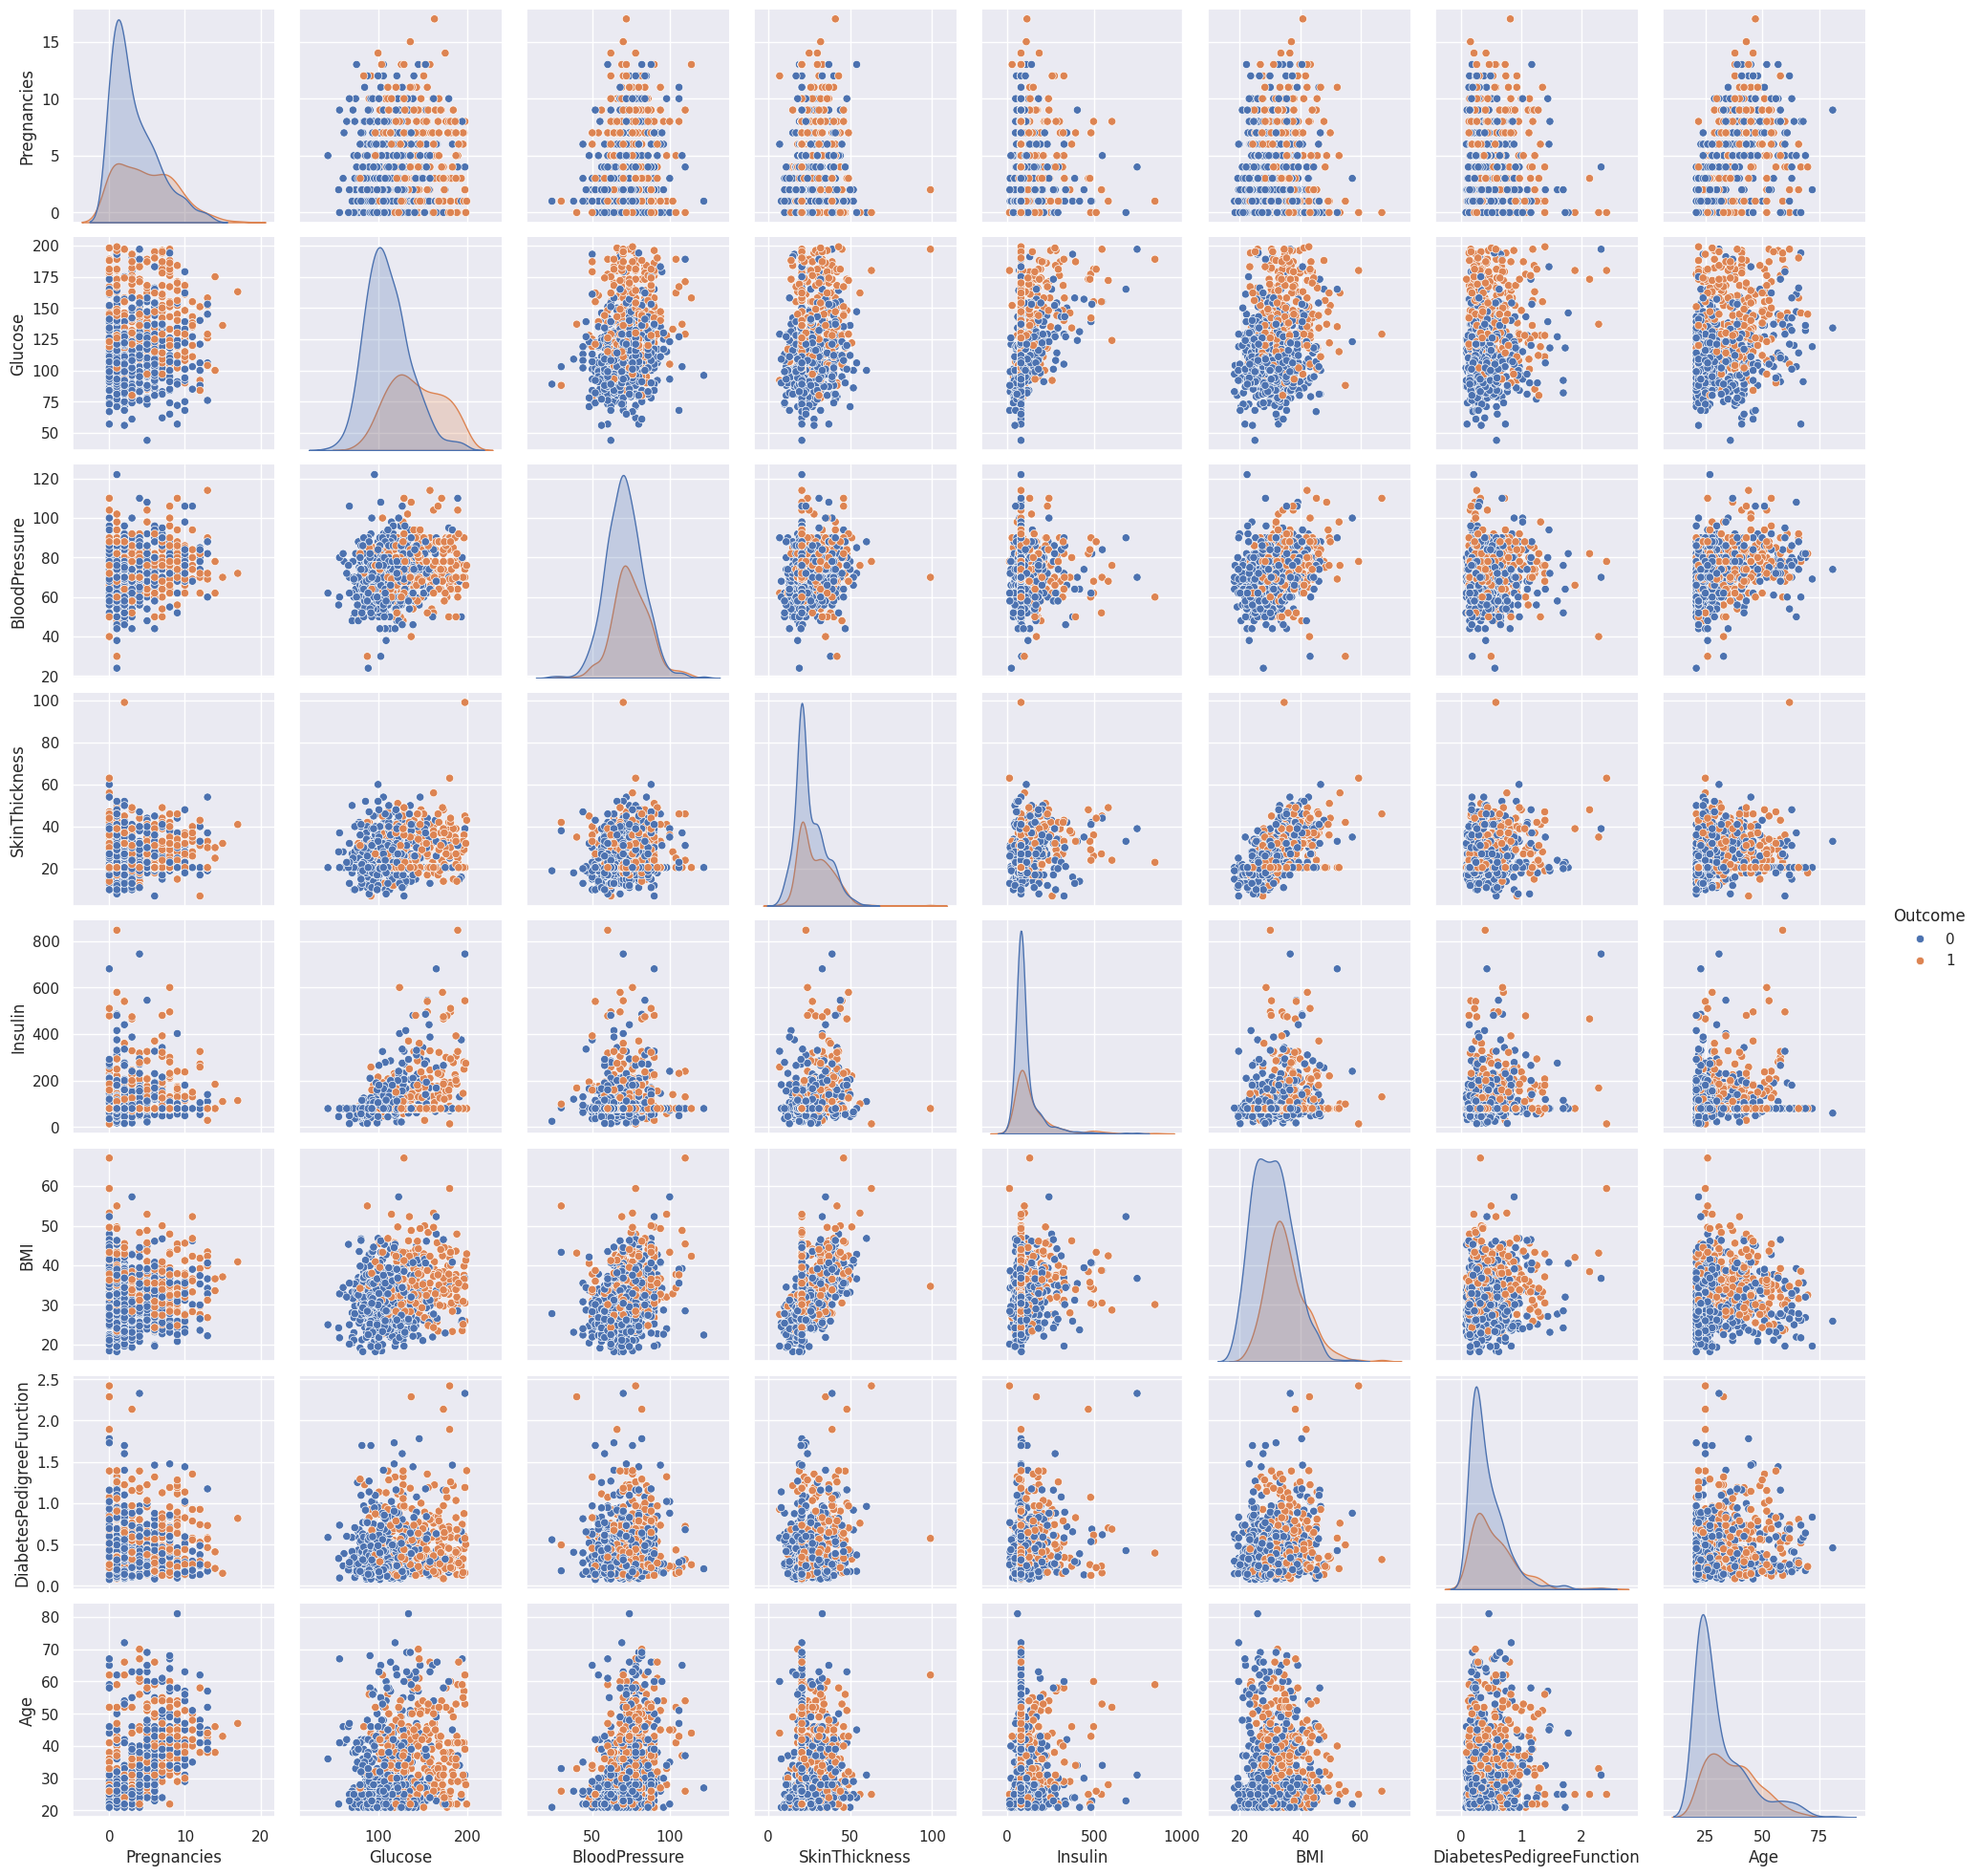

In [16]:
# pairplot
sns.pairplot(df, hue='Outcome', diag_kind='kde')

Glucose seems can classify the outcome to some extent.

In [19]:
# check the skewness of the Outcome variable
from scipy.stats import skew
skew(df)

array([0.89991194, 0.53218273, 0.17271204, 1.22427282, 3.28539219,
       0.59992851, 1.9161592 , 1.12738926, 0.6337757 ])

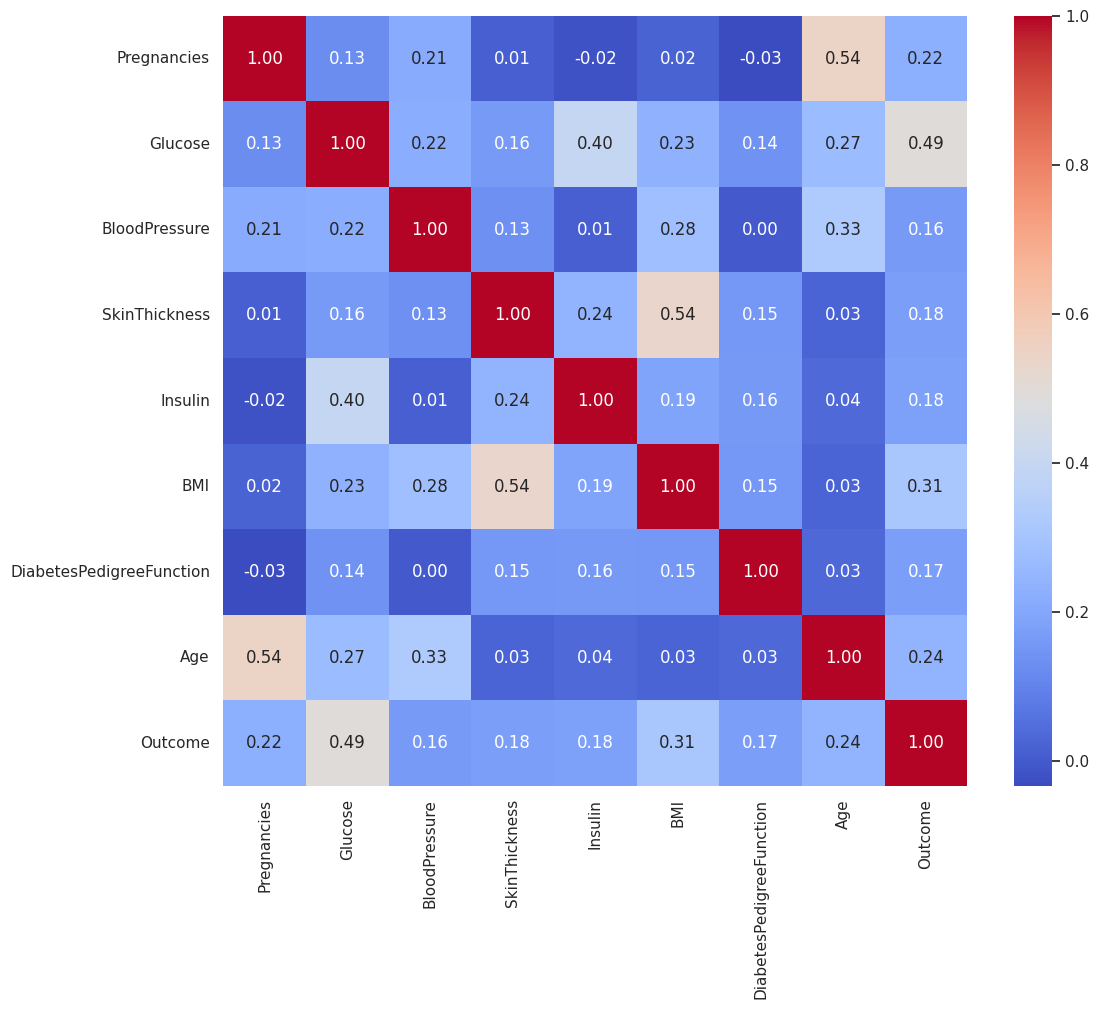

In [20]:
# plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

### Model

Accuracy: 0.7696001367054
Training accuracy: 0.757328990228013
Test accuracy: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        99
           1       0.70      0.60      0.65        55

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154



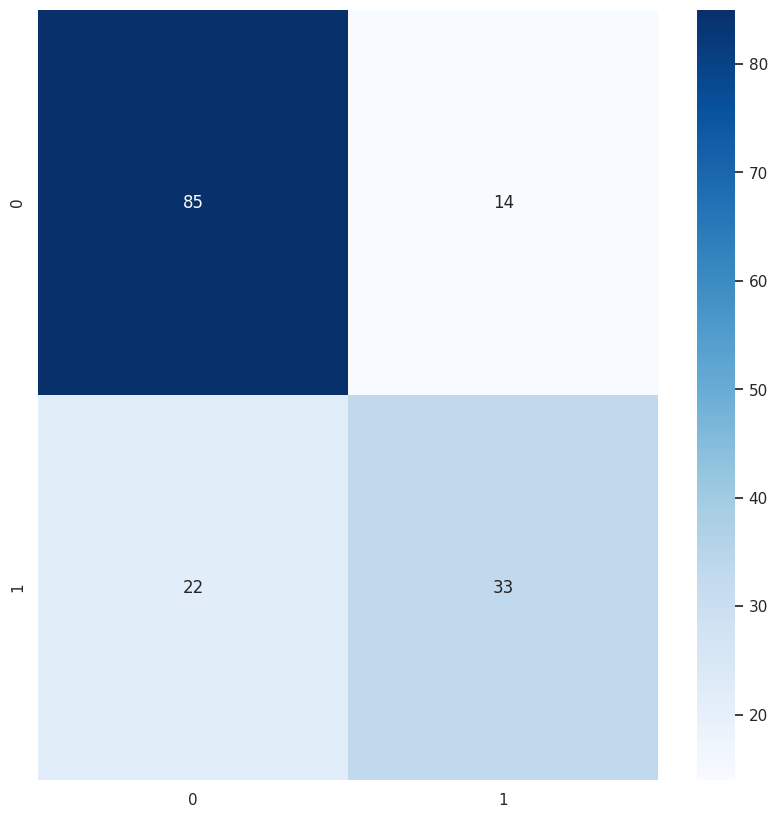

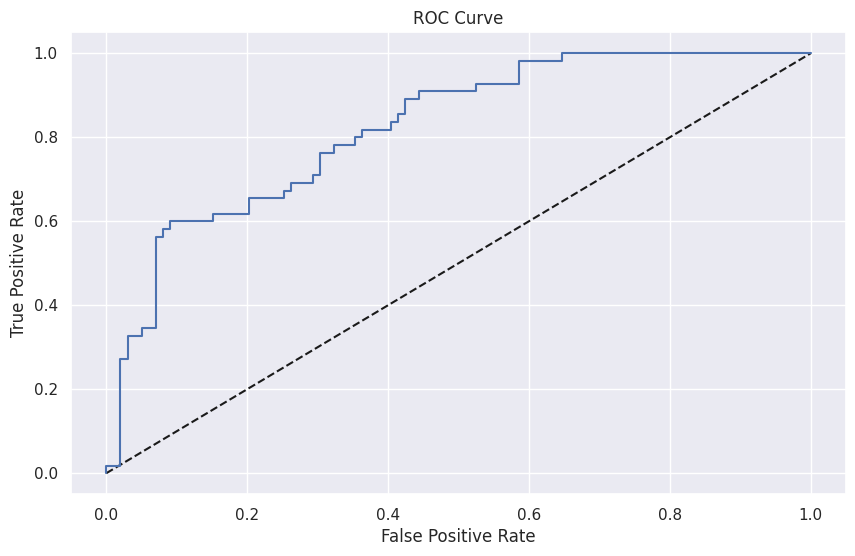

In [7]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_openml

# Prepare features (X) and target (y)
X = df.drop(columns=['Outcome'], axis=1)
y = df['Outcome']

kf = KFold(n_splits=10, shuffle=True)

# Create pipeline with minmax features and logistic regression
model = Pipeline([
    ('scaler', MinMaxScaler()),  # Add scaling as part of the pipeline
    ('logreg', LogisticRegression())
])

# Cross-validation to evaluate the model with MSE scoring
res = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
print('Accuracy:', res.mean())

# print classification report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print the training and test accuracy
print('Training accuracy:', model.score(X_train, y_train))
print('Test accuracy:', model.score(X_test, y_test))

print(classification_report(y_test, y_pred))

# plot the confusion matrix
rcParams['figure.figsize'] = 10,10
sns.set(font_scale = 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


# plot the ROC curve
# new plot
plt.figure(figsize=(10, 6))
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### More models and find the best one

In [8]:
# !pip install XGBoost

Training Logistic Regression...


/tmp/ipykernel_12503/2853061930.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Training Decision Tree...
Training SVC...
Training Random Forest...
Training XGBoost...
                 Model                                        Best Params  \
0  Logistic Regression  {'logisticregression__C': 1, 'logisticregressi...   
1        Decision Tree  {'decisiontree__max_depth': 5, 'decisiontree__...   
2                  SVC            {'svc__C': 10, 'svc__kernel': 'linear'}   
3        Random Forest  {'randomforest__max_depth': None, 'randomfores...   
4              XGBoost  {'xgboost__learning_rate': 0.1, 'xgboost__max_...   

   CV Accuracy  Test Accuracy       AUC  Precision    Recall  
0     0.765636       0.766234  0.821855   0.696680  0.705572  
1     0.743336       0.798701  0.844169   0.735973  0.623377  
2     0.766934       0.759740  0.821212   0.702295  0.705667  
3     0.778742       0.753247  0.826263   0.690341  0.626877  
4     0.760629       0.740260  0.822590   0.711812  0.706041  


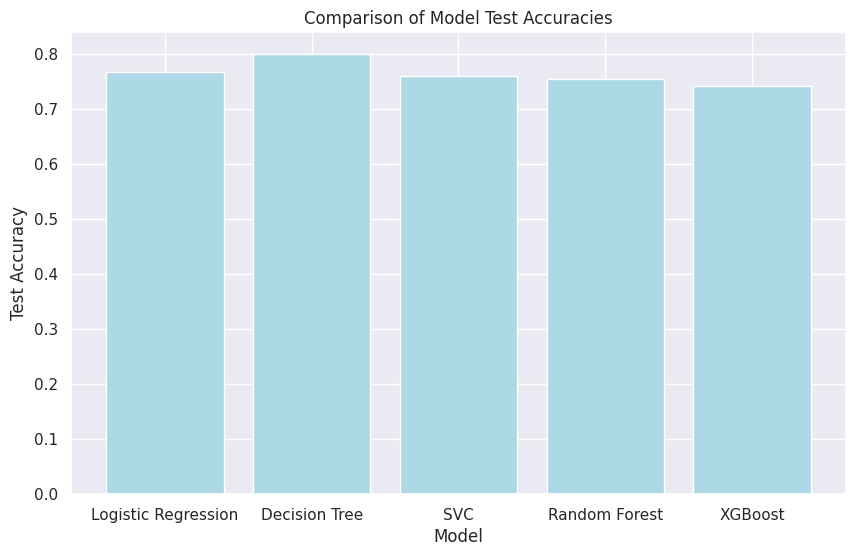

In [16]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import seaborn as sns
from sklearn.pipeline import Pipeline

# Prepare features (X) and target (y)
X = df.drop(columns=['Outcome'], axis=1)
y = df['Outcome']

# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVC': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')  # XGBoost specific evaluation metric
}

# Hyperparameter grids for GridSearchCV
param_grids = {
    'Logistic Regression': {
        'logisticregression__C': [0.01, 0.1, 1, 10],
        'logisticregression__solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'decisiontree__max_depth': [None, 5, 10, 15],
        'decisiontree__min_samples_split': [2, 5, 10]
    },
    'SVC': {
        'svc__C': [0.01, 0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf']
    },
    'Random Forest': {
        'randomforest__n_estimators': [50, 100, 200],
        'randomforest__max_depth': [None, 10, 20]
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100],
        'xgboost__max_depth': [3, 6],
        'xgboost__learning_rate': [0.01, 0.1]
    }
}

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Best Params', 'CV Accuracy', 'Test Accuracy', 'AUC', 'Precision', 'Recall'])

# Loop through each model and perform GridSearchCV with cross-validation
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Create pipeline with MinMaxScaler and the current model
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Add scaling as part of the pipeline
        (model_name.lower().replace(" ", ""), model)  # Model-specific step in the pipeline
    ])

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=kf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    
    # Store the best parameters and results
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Cross-validation accuracy
    cv_accuracy = grid_search.best_score_

    # Test set performance (using holdout split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    # Calculate test accuracy, AUC, precision, recall
    test_accuracy = accuracy_score(y_test, y_pred)
    y_pred_prob = best_model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred_prob)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)
    
    # Save the results in the DataFrame
    results = pd.concat([results, pd.DataFrame({
        'Model': [model_name],
        'Best Params': [best_params],
        'CV Accuracy': [cv_accuracy],
        'Test Accuracy': [test_accuracy],
        'AUC': [auc_score],
        'Precision': [average_precision],
        'Recall': [recall.mean()]
    })], ignore_index=True)

# Display the results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Results", dataframe=results)
print(results.head())

# Plot the comparison of models
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['Test Accuracy'], color='lightblue')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Test Accuracies')
plt.show()

In [18]:
results['Best Params'].iloc[1]

{'decisiontree__max_depth': 5, 'decisiontree__min_samples_split': 2}

Bias Variance

Polynomial features

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best parameters from GridSearchCV:  {'poly__degree': 1, 'scaler__with_mean': True, 'scaler__with_std': True}
Accuracy of best model: 0.7799479166666666
AUC of best model: 0.8457611940298506


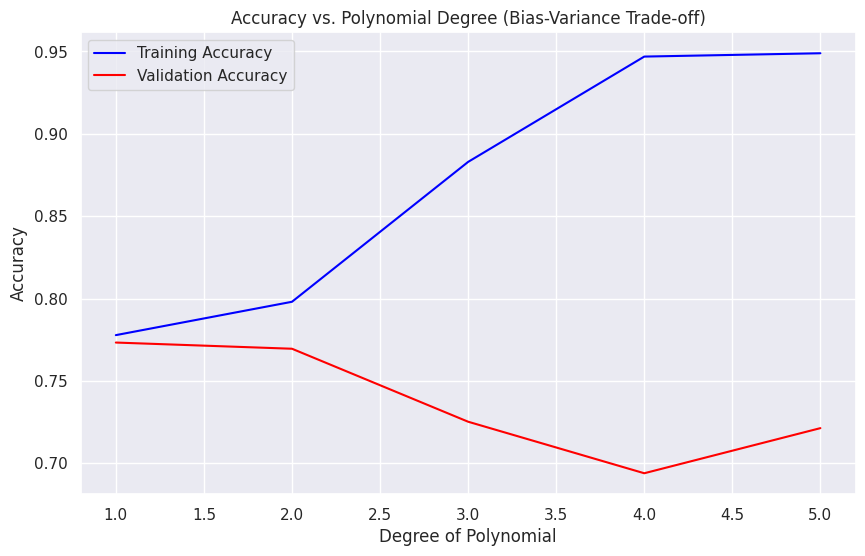

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_scaler__with_mean,param_scaler__with_std,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013950,0.007841,0.004186,0.002285,1,True,True,"{'poly__degree': 1, 'scaler__with_mean': True,...",0.766234,0.818182,...,0.714286,0.831169,0.753247,0.870130,0.766234,0.671053,0.723684,0.768045,0.056048,1
1,0.049127,0.032844,0.003761,0.001684,1,True,False,"{'poly__degree': 1, 'scaler__with_mean': True,...",0.766234,0.805195,...,0.701299,0.831169,0.753247,0.883117,0.766234,0.671053,0.723684,0.766746,0.058863,4
2,0.049299,0.021339,0.007800,0.007129,1,False,True,"{'poly__degree': 1, 'scaler__with_mean': False...",0.766234,0.818182,...,0.714286,0.831169,0.753247,0.870130,0.766234,0.671053,0.723684,0.768045,0.056048,1
3,0.063172,0.023700,0.008051,0.005182,1,False,False,"{'poly__degree': 1, 'scaler__with_mean': False...",0.740260,0.818182,...,0.688312,0.818182,0.779221,0.870130,0.766234,0.684211,0.710526,0.764149,0.057354,5
4,0.025286,0.006772,0.004332,0.001716,2,True,True,"{'poly__degree': 2, 'scaler__with_mean': True,...",0.727273,0.805195,...,0.688312,0.818182,0.818182,0.831169,0.701299,0.697368,0.763158,0.759040,0.052770,6
5,0.037327,0.008107,0.006597,0.003742,2,True,False,"{'poly__degree': 2, 'scaler__with_mean': True,...",0.623377,0.753247,...,0.584416,0.662338,0.714286,0.753247,0.714286,0.618421,0.763158,0.687509,0.059957,19
6,0.046188,0.014542,0.004306,0.002487,2,False,True,"{'poly__degree': 2, 'scaler__with_mean': False...",0.740260,0.818182,...,0.688312,0.792208,0.818182,0.883117,0.727273,0.697368,0.750000,0.766815,0.057593,3
7,0.038856,0.010989,0.006359,0.005500,2,False,False,"{'poly__degree': 2, 'scaler__with_mean': False...",0.649351,0.753247,...,0.636364,0.766234,0.740260,0.740260,0.675325,0.618421,0.736842,0.696565,0.053054,15
8,0.036098,0.002411,0.004692,0.003474,3,True,True,"{'poly__degree': 3, 'scaler__with_mean': True,...",0.675325,0.766234,...,0.701299,0.766234,0.818182,0.779221,0.727273,0.684211,0.684211,0.727751,0.048762,10
9,0.039030,0.002673,0.003553,0.000185,3,True,False,"{'poly__degree': 3, 'scaler__with_mean': True,...",0.623377,0.779221,...,0.675325,0.792208,0.753247,0.779221,0.766234,0.710526,0.723684,0.720044,0.064758,11


In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Set up KFold cross-validation
kf = KFold(n_splits=10, shuffle=True)

# GridSearchCV with Polynomial Regression (to select best degree and regularization)
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],  # Polynomial degrees from 1 to 5
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False]
}

# Set up GridSearchCV with the Polynomial Regression pipeline (Logistic Regression for classification)
grid = GridSearchCV(Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for preprocessing
    ('poly', PolynomialFeatures()),  # Polynomial feature transformation
    ('logreg', LogisticRegression())  # Logistic Regression model for classification
]), param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid.fit(X, y)

# Display best parameters from GridSearchCV
print("Best parameters from GridSearchCV: ", grid.best_params_)

# Evaluate performance of the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X)

# Calculate Accuracy and AUC
accuracy = accuracy_score(y, y_pred)
y_pred_prob = best_model.predict_proba(X)[:, 1]
auc = roc_auc_score(y, y_pred_prob)

print(f'Accuracy of best model: {accuracy}')
print(f'AUC of best model: {auc}')

# Evaluate using the validation curve to analyze bias-variance trade-off
train_score, val_score = validation_curve(
    best_model, X, y, param_name="poly__degree", param_range=[1, 2, 3, 4, 5], cv=kf, scoring='accuracy'
)

# Plot Accuracy for different polynomial degrees to observe the bias-variance trade-off
plt.figure(figsize=(10, 6))
plt.plot([1, 2, 3, 4, 5], np.mean(train_score, axis=1), label='Training Accuracy', color='blue')
plt.plot([1, 2, 3, 4, 5], np.mean(val_score, axis=1), label='Validation Accuracy', color='red')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Polynomial Degree (Bias-Variance Trade-off)')
plt.legend()
plt.show()

# Display GridSearchCV Results (cross-validation performance)
results_df = pd.DataFrame(grid.cv_results_)
results_df


Best parameters from GridSearchCV:  {'model__max_depth': 2}
Accuracy of best model: 0.7708333333333334
AUC of best model: 0.7938171641791045


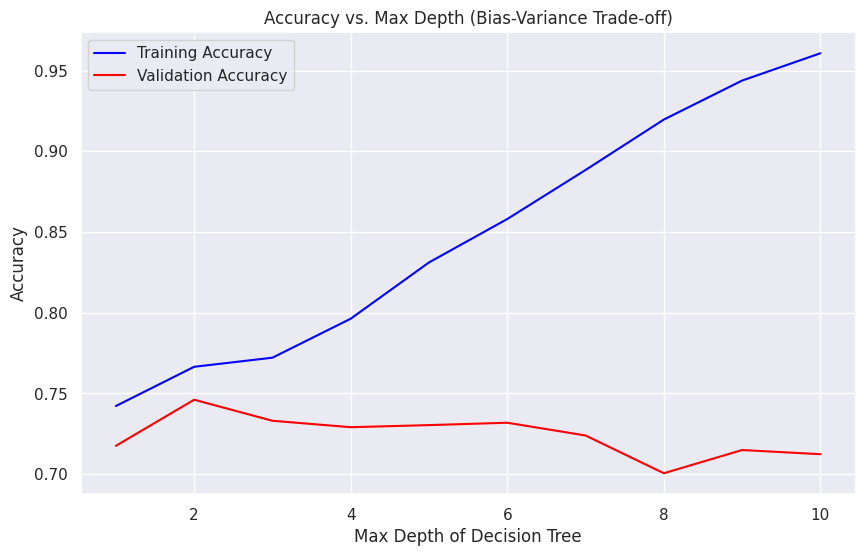

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006590,0.001803,0.003953,0.002903,1,{'model__max_depth': 1},0.818182,0.792208,0.727273,0.688312,0.740260,0.688312,0.766234,0.610390,0.684211,0.671053,0.718643,0.059275,7
1,0.006455,0.002103,0.007293,0.006435,2,{'model__max_depth': 2},0.844156,0.831169,0.727273,0.766234,0.740260,0.688312,0.818182,0.610390,0.710526,0.697368,0.743387,0.069401,1
2,0.007675,0.002843,0.003014,0.000061,3,{'model__max_depth': 3},0.870130,0.818182,0.727273,0.727273,0.805195,0.623377,0.792208,0.610390,0.710526,0.671053,0.735560,0.081346,3
3,0.006642,0.000197,0.002901,0.000142,4,{'model__max_depth': 4},0.727273,0.792208,0.727273,0.688312,0.740260,0.727273,0.792208,0.610390,0.684211,0.763158,0.725256,0.051849,5
4,0.007743,0.001841,0.003294,0.000775,5,{'model__max_depth': 5},0.766234,0.792208,0.779221,0.727273,0.805195,0.688312,0.753247,0.636364,0.723684,0.684211,0.735595,0.051124,2
5,0.007591,0.000211,0.002878,0.000134,6,{'model__max_depth': 6},0.792208,0.766234,0.779221,0.740260,0.740260,0.675325,0.766234,0.636364,0.723684,0.671053,0.729084,0.049389,4
6,0.007267,0.000376,0.002987,0.000100,7,{'model__max_depth': 7},0.714286,0.753247,0.792208,0.753247,0.740260,0.623377,0.792208,0.636364,0.723684,0.684211,0.721309,0.055399,6
7,0.007747,0.000181,0.002911,0.000123,8,{'model__max_depth': 8},0.740260,0.779221,0.779221,0.727273,0.740260,0.649351,0.740260,0.623377,0.710526,0.657895,0.714764,0.051282,8
8,0.008297,0.000205,0.002562,0.000129,9,{'model__max_depth': 9},0.701299,0.779221,0.766234,0.714286,0.688312,0.623377,0.779221,0.597403,0.736842,0.618421,0.700461,0.064567,10
9,0.009558,0.000983,0.003114,0.000670,10,{'model__max_depth': 10},0.753247,0.766234,0.701299,0.753247,0.714286,0.649351,0.766234,0.610390,0.763158,0.631579,0.710902,0.057208,9


In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Set up KFold cross-validation
kf = KFold(n_splits=10, shuffle=True)

# Define parameter grid for Decision Tree's max_depth
param_grid = {
    'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Exploring max_depth from 1 to 10
}

# Set up GridSearchCV with the Decision Tree pipeline
grid = GridSearchCV(Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for preprocessing
    ('model', DecisionTreeClassifier())  # Decision Tree model
]), param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid.fit(X, y)

# Display best parameters from GridSearchCV
print("Best parameters from GridSearchCV: ", grid.best_params_)

# Evaluate performance of the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X)

# Calculate Accuracy and AUC
accuracy = accuracy_score(y, y_pred)
y_pred_prob = best_model.predict_proba(X)[:, 1]
auc = roc_auc_score(y, y_pred_prob)

print(f'Accuracy of best model: {accuracy}')
print(f'AUC of best model: {auc}')

# Evaluate using the validation curve to analyze bias-variance trade-off
train_score, val_score = validation_curve(
    best_model, X, y, param_name="model__max_depth", param_range=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], cv=kf, scoring='accuracy'
)

# Plot Accuracy for different max_depth values to observe the bias-variance trade-off
plt.figure(figsize=(10, 6))
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], np.mean(train_score, axis=1), label='Training Accuracy', color='blue')
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], np.mean(val_score, axis=1), label='Validation Accuracy', color='red')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Depth (Bias-Variance Trade-off)')
plt.legend()
plt.show()

# Display GridSearchCV Results (cross-validation performance)
results_df = pd.DataFrame(grid.cv_results_)
results_df
